# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
0.6486199043350842
-0.6696557971014493


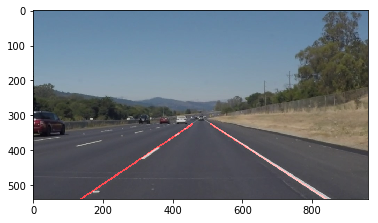

In [128]:
lane_marker()

def lane_marker(img_file='test_images/solidWhiteRight.jpg'):
    #reading in an image
    image = mpimg.imread(img_file)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimesions:', image.shape)

    # set key site range
    imshape = image.shape
    bottom = imshape[0] #also used for extrapolating results
    top = 325           #also used for extrapolating results
    vert_bot_left = (100, bottom)
    vert_top_left = (425, top)
    vert_top_right = (550, top)
    vert_bot_right = (900, bottom)

    #make gray
    gray = grayscale(image)

    #apply Gaussian smoothing
    gaussian_kernel = 3
    blur_gray = gaussian_blur(gray, 5)

    #get Canny edges
    canny_low = 10
    canny_high = 250
    edges = canny(blur_gray, canny_low, canny_high)

    #mask edges
    vertices = np.array([[vert_bot_left, vert_top_left, 
                           vert_top_right, vert_bot_right]], dtype = np.int32)
    masked_edges = region_of_interest(edges, vertices)

    #find lines with Hough transform
    hl_rho = 1
    hl_theta = np.pi/360
    hl_threshold = 15
    hl_min_line_len = 5
    hl_max_line_gap = 10
    #don't want to image from hough_lines, want the line instead 
    #h_lines_image = hough_lines(masked_edges, hl_rho, hl_theta, hl_threshold, 
    #                            hl_min_line_len, hl_max_line_gap)
    #get lines instead of image
    hough_lines = cv2.HoughLinesP(masked_edges, hl_rho, hl_theta, hl_threshold, np.array([]), 
                                   hl_min_line_len, hl_max_line_gap)

    # get full lane lines
    lane_lines = get_lane_lines(hough_lines, top, bottom)
    lane_line_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    #draw lane lines
    color = [255, 0, 0]
    thickness = 4
    l_x1, l_y1, l_x2, l_y2 = get_line_points(lane_lines[0])
    r_x1, r_y1, r_x2, r_y2 = get_line_points(lane_lines[1])
    cv2.line(lane_line_image, (l_x1, l_y1), (l_x2, l_y2), color, thickness)
    cv2.line(lane_line_image, (r_x1, r_y1), (r_x2, r_y2), color, thickness)

    #create weighted image
    w_image = weighted_img(lane_line_image, image)

    #show image
    plt.imshow(w_image)  

    return w_image


**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [141]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def get_lane_lines(lines_in, top, bottom):
    """
    Separates lines w/ positive and negative slope, removes outliers and returns an average
    two average lines for left and right side
    """
    expected_slope = 0.65   #based on straight lines in initial image
    slope_tolerance = 0.2  #can be tweaked to control noise/allow curvature, etc.
    slope_min = expected_slope - slope_tolerance
    slope_max = expected_slope + slope_tolerance
    
    #exception catch added for challenge video when sometimes no lines were detected
    try:
        # separate lines by side...all slopes should be close to expected slope
        left_lines = [line for line in lines_in if \
                      (line_slope(line[0]) > slope_min and line_slope(line[0]) < slope_max)]
        right_lines = [line for line in lines_in if \
                      (line_slope(line[0]) < -slope_min and line_slope(line[0]) > -slope_max)]

        #get one line out of group
        left_line = get_one_line(left_lines, top, bottom)
        right_line = get_one_line(right_lines, top, bottom)

        #return lines
        return [left_line, right_line]
    except:
        return

def get_one_line(line_group, top, bottom):
    """
    Returns one line segment as an average of all lines in the group.  
    Top and bottom are the max and minimum y values for the segment.
    """
    if line_group is None:
        return []  # in case no lines were found
    else:
        #remove outliers
        lines = clear_outliers(line_group)
        #set average line
        slope, b = get_avg_slope_plus_b(lines)
        line = set_new_line(slope, b, top, bottom)
        
        return line

def clear_outliers(lines):
    """
    Removes any additional outliers before creating an average.
    This was originally used before narrowing in on expected slope + tolerance,
    but left in to better refine the accuracy of the lines
    """
    slopes = []
    for i in range(len(lines)):
        slopes.append(line_slope(lines[i][0]))
    slopes = np.array(slopes)
    avg_slope = np.mean(slopes)  # average slope
    std_slope = np.std(slopes)   # standard deviation of the slope
    new_lines = []
    for j in range(len(lines)):
        #only keep lines within 1 standard deviation of the slope
        if abs(slopes[j] - avg_slope) < std_slope:
            new_lines.append(lines[j])
    return new_lines
    

def set_new_line(slope, b, min_y, max_y):
    """
    Returns four points in a list representing x1, y1, x2, y2 for new line segment with
    slope, b, maximim x, and minimum x defined
    """
    y1 = min_y
    y2 = max_y
    x1 = int(round((float(y1) - b) / slope))
    x2 = int(round((float(y2) - b) / slope))
    return [x1, y1, x2, y2]
        
def get_avg_slope_plus_b(lines):
    """
    Returns average slope and y intercept from a list of lines
    """
    count = 0.
    slope_sum = 0.
    b_sum = 0.

    for line in lines:
        my_slope = line_slope(line[0])
        slope_sum += my_slope
        b_sum += line_b(line[0][0], line[0][1], my_slope)
        count += 1.
    return slope_sum / count, b_sum / count
    
def line_b(x, y, slope):
    """
    returns y-intercept given a point on a line and slope
    """
    return float(y) - slope * float(x)

def line_slope(line):
    """
    returns the slope of a line segment (four points)
    """
    if (line[2] - line[0]) == 0:
        return
    else:
        return float(line[3] - line[1]) / float(line[2] - line[0])

def get_line_points(line):
    """
    helper to separate points from a line
    """
    x1 = line[0]
    y1 = line[1]
    x2 = line[2]
    y2 = line[3]
    return x1, y1, x2, y2

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [79]:
import os
os.listdir("test_images/")

['solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg']

run your solution on all test_images and make copies into the test_images directory).

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


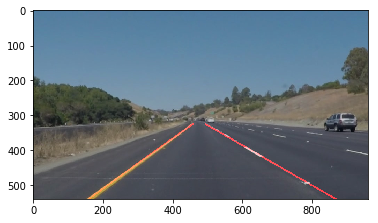

In [142]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
file_dir = "test_images/"
file_list = os.listdir(file_dir)
for f in file_list:
    image = lane_marker(file_dir + f)
    mpimg.imsave(file_dir+"lined-"+f[:-4]+".png", image)
    


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [143]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [151]:
def process_image(image):
     
    # set key site range
    imshape = image.shape
    #original shape ratios based on 540x960, adjusting for different sizes
    bottom = imshape[0]                        #also used for extrapolating results
    top = int(round(float(imshape[0]) * 325. / 540.)) #also used for extrapolating results
    low_left = int(round(float(imshape[1]) * 100. / 960.))
    high_left = int(round(float(imshape[1]) * 425. / 960.))
    high_right = int(round(float(imshape[1]) * 575. / 960.))
    low_right = int(round(float(imshape[1]) * 900. / 960.))
    vert_bot_left = (low_left, bottom)
    vert_top_left = (high_left, top)
    vert_top_right = (high_right, top)
    vert_bot_right = (low_right, bottom)

    #make gray
    gray = grayscale(image)
    #try color
    #im_color = cv2.applyColorMap(gray, cv2.COLORMAP_BONE)

    #apply Gaussian smoothing
    gaussian_kernel = 3
    blur_gray = gaussian_blur(gray, 5)

    #get Canny edges
    canny_low = 5
    canny_high = 100
    edges = canny(blur_gray, canny_low, canny_high)

    #mask edges
    vertices = np.array([[vert_bot_left, vert_top_left, 
                           vert_top_right, vert_bot_right]], dtype = np.int32)
    masked_edges = region_of_interest(edges, vertices)

    #find lines with Hough transform
    hl_rho = 1
    hl_theta = np.pi/360
    hl_threshold = 15
    hl_min_line_len = 20  #5
    hl_max_line_gap = 5 #10
    #don't want to image from hough_lines, want the line instead 
    #h_lines_image = hough_lines(masked_edges, hl_rho, hl_theta, hl_threshold, 
    #                            hl_min_line_len, hl_max_line_gap)
    #get lines instead of image
    hough_lines = cv2.HoughLinesP(masked_edges, hl_rho, hl_theta, hl_threshold, np.array([]), 
                                   hl_min_line_len, hl_max_line_gap)

    # get full lane lines
    lane_lines = get_lane_lines(hough_lines, top, bottom)

    # add lines if lines found
    if lane_lines is None:
        result = image # no lane lines
    else:
        color = [255, 0, 0]
        thickness = 4
        lane_line_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        l_x1, l_y1, l_x2, l_y2 = get_line_points(lane_lines[0])
        r_x1, r_y1, r_x2, r_y2 = get_line_points(lane_lines[1])
        cv2.line(lane_line_image, (l_x1, l_y1), (l_x2, l_y2), color, thickness)
        cv2.line(lane_line_image, (r_x1, r_y1), (r_x2, r_y2), color, thickness)

        #create weighted image
        result = weighted_img(lane_line_image, image, α=0.9)

    return result

Let's try the one with the solid white lane on the right first ...

In [145]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


Exception ignored in: <bound method VideoFileClip.__del__ of <moviepy.video.io.VideoFileClip.VideoFileClip object at 0x7fe9f0621128>>
Traceback (most recent call last):
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/moviepy/video/io/VideoFileClip.py", line 86, in __del__
    del self.reader
AttributeError: reader

100%|█████████▉| 221/222 [00:04<00:00, 51.07it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.87 s, sys: 176 ms, total: 4.04 s
Wall time: 4.81 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [146]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [147]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4



100%|█████████▉| 681/682 [00:14<00:00, 48.57it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 12.2 s, sys: 540 ms, total: 12.7 s
Wall time: 14.5 s


In [148]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [152]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4



100%|██████████| 251/251 [00:09<00:00, 26.15it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 7.22 s, sys: 276 ms, total: 7.49 s
Wall time: 10.5 s


In [153]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))